<a href="https://colab.research.google.com/github/rodrigo0345/Aprof2/blob/main/Task1_ViT_VGG_AutoEncoder_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Compose, Lambda, Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
import torch
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Normalize
import torch.optim as optim
import seaborn as sns

# openpyxl é preciso ser instalado para TPUs
!pip install decord openpyxl
import decord
from decord import VideoReader
import os
# from torchinfo import summary
# from livelossplot import PlotLosses

np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 83.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "drive/MyDrive/suturas-filtered/"
labels_path = "drive/MyDrive/OSATS.xlsx"

info_df = pd.read_excel(labels_path)

# Get list of video files in the directory
video_files = [f.replace("output_prewitt_", "").replace(".mp4", "") for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith(('.mp4', '.avi', '.mov'))]
video_column = 'VIDEO'

info_df = info_df[info_df[video_column].isin(video_files)]
print(f"Number of videos after filtering: {len(info_df)}")

# Filter only 10 videos because of resources limitation
info_df = info_df.iloc[:10]
info_df.head()


Number of videos after filtering: 90


,STUDENT,GROUP,TIME,SUTURES,INVESTIGATOR,VIDEO,OSATS_RESPECT,OSATS_MOTION,OSATS_INSTRUMENT,OSATS_SUTURE,OSATS_FLOW,OSATS_KNOWLEDGE,OSATS_PERFORMANCE,OSATS_FINAL_QUALITY,GLOBA_RATING_SCORE
21,ALN135,E-LEARNING,POST,3.5,A,A61V,4,2,3,3,2,3,3,4,24
22,ALN135,E-LEARNING,POST,3.5,B,A61V,4,3,4,3,3,4,3,4,28
23,ALN135,E-LEARNING,POST,3.5,C,A61V,4,3,2,3,3,3,3,3,24
42,BOG917,HMD-BASED,PRE,2.5,A,C16G,3,3,3,2,2,2,2,1,18
43,BOG917,HMD-BASED,PRE,2.5,B,C16G,2,2,3,2,3,3,3,3,21


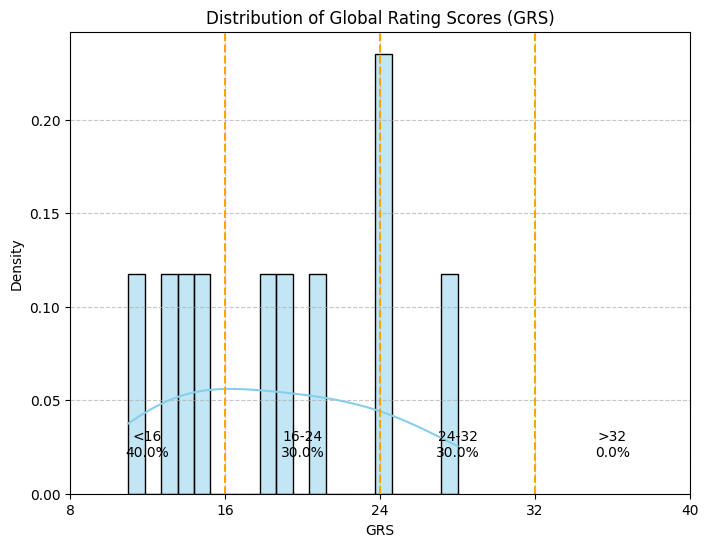

In [ ]:
# Dataset analysis
def plot_grs_distribution(df):
    grs_scores = df['GLOBA_RATING_SCORE'].dropna().values

    if len(grs_scores) == 0:
        print("No GRS scores available to plot.")
        return

    plt.figure(figsize=(8, 6))

    sns.histplot(grs_scores, bins=20, kde=True, stat="density", color="skyblue", alpha=0.5)
    thresholds = [16, 24, 32]
    for threshold in thresholds:
        plt.axvline(threshold, color="orange", linestyle="--", linewidth=1.5)

    total_videos = len(grs_scores)
    bin_percentages = [
        np.sum(grs_scores < 16) / total_videos * 100,  # <16
        np.sum((grs_scores >= 16) & (grs_scores < 24)) / total_videos * 100,  # 16-24
        np.sum((grs_scores >= 24) & (grs_scores < 32)) / total_videos * 100,  # 24-32
        np.sum(grs_scores >= 32) / total_videos * 100  # >=32
    ]

    plt.text(12, 0.02, f"<16\n{bin_percentages[0]:.1f}%", ha="center", color="black")
    plt.text(20, 0.02, f"16-24\n{bin_percentages[1]:.1f}%", ha="center", color="black")
    plt.text(28, 0.02, f"24-32\n{bin_percentages[2]:.1f}%", ha="center", color="black")
    plt.text(36, 0.02, f">32\n{bin_percentages[3]:.1f}%", ha="center", color="black")

    plt.xlabel("GRS")
    plt.ylabel("Density")
    plt.title("Distribution of Global Rating Scores (GRS)")
    plt.xticks(np.arange(8, 41, 8))
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

plot_grs_distribution(info_df)

In [ ]:
# used for Task #1
def get_global_rating_score(video: str):
  try:
    score = info_df[info_df['VIDEO'] == video]['GLOBA_RATING_SCORE'].iloc[0]
    # Get GRS score, nota: acho que até é melhor dividir primeiro por
    if score < 16:
      score = 0
    elif score < 24:
      score = 1
    elif score < 32:
      score = 2
    elif score < 40:
      score = 3
    return score
  except:
    print(f"Video {video} not found")


# used for Task #2
def get_vector_of_ratings(video: str):
  video_data = info_df[info_df['VIDEO'] == video]
  osats_columns = ['OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
                    'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
                    'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY']
  return video_data[osats_columns].iloc[0].values.tolist()

print(get_global_rating_score("A61V"))
print(get_vector_of_ratings("A61V"))

def update_info_df_with_binned_grs(df):
    updated_df = df.copy()
    binned_scores = updated_df['VIDEO'].apply(get_global_rating_score)
    updated_df['GLOBA_RATING_SCORE'] = binned_scores
    if binned_scores.isnull().any():
        print("Warning: Some videos were not found. Corresponding GRS values are None.")
    return updated_df

# change the dataframe to have GRS
info_df = update_info_df_with_binned_grs(info_df)

2
[4, 2, 3, 3, 2, 3, 3, 4]


In [ ]:
print(info_df.index)

Index([21, 22, 23, 42, 43, 44, 108, 109, 110, 144], dtype='int64')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
         for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

print(device)

cpu


In [ ]:
train_transform = Compose(
        [ToTensor(),
         Normalize(mean=(0.1307,), std=(0.3081,)) # TODO: acho que devia remover isto
        ])
test_transform = Compose(
        [ToTensor(),
         Normalize(mean=(0.1307,), std=(0.3081,)) # TODO: acho que devia remover isto
        ])

In [ ]:
batch_size = 1
segments = 16

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, df_dataset, cfg, dataset_path, segments, segment_frame_pos=0) -> None:
        super().__init__()
        self.df_dataset = df_dataset
        self.dataset_path = dataset_path
        self.cfg = cfg
        self.label = "GLOBA_RATING_SCORE"  # Default to Task 1
        self._segments = segments
        self._segment_frame_pos = segment_frame_pos

    def __len__(self):
        return len(self.df_dataset)

    def set_task_one(self):
        self.label = "GLOBA_RATING_SCORE"

    def set_task_two(self):
        self.label = [
            'OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
            'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
            'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY'
        ]

    def __getitem__(self, idx):
        video_path = os.path.join(self.dataset_path, "output_prewitt_" + self.df_dataset.iloc[idx]["VIDEO"] + ".mp4")
        vr = decord.VideoReader(video_path)
        total_frames = len(vr)

        num_frames = self.cfg["num_frames"]
        if total_frames >= num_frames:
            indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        else:
            indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)

        if self._segments is not None:
          # Divide indices into subsets
          subsets = np.array_split(indices, self._segments)
          # Retrieve the first element of each subset
          indices = [subset[self._segment_frame_pos] for subset in subsets]

        frames = vr.get_batch(indices).asnumpy()  # [T, H, W, C], uint8

        # Convert to tensor and normalize to [0, 1]
        frames = torch.from_numpy(frames).float() / 255.0

        # Permute to [T, C, H, W]
        frames = frames.permute(0, 3, 1, 2)

        # Normalize with mean and std
        mean = [0.45, 0.45, 0.45]
        std = [0.225, 0.225, 0.225]
        normalize = Normalize(mean, std)
        frames = normalize(frames)

        # Short side scale
        side_size = 256
        H, W = vr[0].shape[0], vr[0].shape[1]
        if H < W:
            new_H = side_size
            new_W = int(side_size * W / H)
        else:
            new_W = side_size
            new_H = int(side_size * H / W)

        # Resize using interpolate
        frames = F.interpolate(frames, size=(new_H, new_W), mode='bilinear', align_corners=False)

        # Center crop to 256x256
        crop_size = 256
        start_h = (new_H - crop_size) // 2
        start_w = (new_W - crop_size) // 2
        frames = frames[:, :, start_h:start_h + crop_size, start_w:start_w + crop_size]

        # Permute to [C, T, H, W] to match expected output
        frames = frames.permute(1, 0, 2, 3)

        if isinstance(self.label, str):  # Task 1: Single label
            label = self.df_dataset.iloc[idx][self.label]
            label = torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor
        else:  # Task 2: Multiple labels
            label = [self.df_dataset.iloc[idx][col] for col in self.label]
            label = torch.tensor(label, dtype=torch.long)  # Convert to tensor

        return frames, label

# task = 1 | 2
def prepare_data_loaders(path_train, task=1, segments=None):
    train_df, temp_df = train_test_split(info_df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    cfg = {
        "num_frames": 64 # isto não me convence muito
    }
    train_dataset = VideoDataset(train_df, cfg, path_train, segments)
    val_dataset = VideoDataset(val_df, cfg, path_train, segments)
    test_dataset = VideoDataset(test_df, cfg, path_train, segments)

    train_dataset.set_task_one() if task == 1 else train_dataset.set_task_two()
    val_dataset.set_task_one() if task == 1 else val_dataset.set_task_two()
    test_dataset.set_task_one() if task == 1 else test_dataset.set_task_two()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

train_dl, val_dl, test_dl = prepare_data_loaders(path, task = 1, segments=segments)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        print("Starting epoch:", epoch)
        for videos, labels in train_loader:

            videos = videos.to(device)
            labels = labels.to(device, dtype=torch.long)  # Ensure labels are long

            optimizer.zero_grad()
            outputs = model(videos)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos = videos.to(device)
                labels = labels.to(device, dtype=torch.long)
                outputs = model(videos)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * videos.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# --- VGG Feature Extractor ---
class VGGEncoder(nn.Module):
    def __init__(self, vgg_model_name='vgg16', pretrained=True, freeze_encoder=True):
        super(VGGEncoder, self).__init__()
        print(f"Loading VGG model for feature extraction: {vgg_model_name}.")
        if vgg_model_name == 'vgg16':
            weights = models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None
            vgg = models.vgg16(weights=weights)
            self.features = vgg.features # Output: (N, 512, H/32, W/32), for 224x224 input -> (N, 512, 7, 7)
            self.feature_dim = 512 # VGG16 features output 512 channels
        elif vgg_model_name == 'vgg19':
            weights = models.VGG19_Weights.IMAGENET1K_V1 if pretrained else None
            vgg = models.vgg19(weights=weights)
            self.features = vgg.features
            self.feature_dim = 512 # VGG19 features also output 512 channels
        else:
            raise ValueError(f"VGG model '{vgg_model_name}' not supported.")

        # Adaptive pooling to get a fixed-size output vector regardless of minor input size variations
        # This will pool the (N, 512, H', W') feature map to (N, 512, 1, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        if freeze_encoder:
            print(f"Freezing VGG encoder weights ({vgg_model_name}).")
            for param in self.features.parameters():
                param.requires_grad = False
        print(f"VGG Encoder ({vgg_model_name}) initialized. Output feature dimension after pooling: {self.feature_dim}")

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1) # Flatten to (N, feature_dim)
        return x

# --- Main Network (ViT Backbone + VGG Encoder + LSTM + FFN) ---
class SutureLSTMNet_ViT_VGG_FFN(nn.Module):
    def __init__(self,
                 num_classes,               # For final FFN classification output
                 vit_model_name='vit_b_16', # Name of the ViT model from torchvision
                 vgg_model_name='vgg16',    # Name of the VGG model for encoder
                 rnn_hidden_size=512,
                 rnn_num_layers=2,
                 ffn_hidden_dims=[256, 128], # List of hidden dimensions for FFN layers
                 ffn_dropout_rate=0.3,
                 freeze_vit_backbone=True,
                 freeze_vgg_encoder=True,
                ):
        super(SutureLSTMNet_ViT_VGG_FFN, self).__init__()

        self.num_classes = num_classes

        # 1. Vision Transformer (ViT) Backbone for Feature Extraction
        print(f"Loading Vision Transformer model: {vit_model_name}.")
        if vit_model_name == 'vit_b_16':
            weights_vit = models.ViT_B_16_Weights.IMAGENET1K_V1
            self.feature_extractor_vit = models.vit_b_16(weights=weights_vit)
            self.vit_embedding_dim = self.feature_extractor_vit.hidden_dim
        elif vit_model_name == 'vit_l_16':
            weights_vit = models.ViT_L_16_Weights.IMAGENET1K_V1
            self.feature_extractor_vit = models.vit_l_16(weights=weights_vit)
            self.vit_embedding_dim = self.feature_extractor_vit.hidden_dim
        else:
            raise ValueError(f"ViT model '{vit_model_name}' not supported.")

        crop_size_list = weights_vit.transforms().crop_size
        if len(crop_size_list) == 1:
            self.target_input_size = (crop_size_list[0], crop_size_list[0])
        elif len(crop_size_list) == 2:
            self.target_input_size = tuple(crop_size_list)
        else:
            raise ValueError(f"Unexpected crop_size format: {crop_size_list}.")

        print(f"Using ViT: {vit_model_name}. Embedding dimension: {self.vit_embedding_dim}. Target input size: {self.target_input_size}")
        self.feature_extractor_vit.heads.head = nn.Identity() # Remove ViT classifier

        if freeze_vit_backbone:
            print("Freezing ViT backbone weights.")
            for param in self.feature_extractor_vit.parameters():
                param.requires_grad = False

        # 2. VGG Encoder for additional Feature Extraction
        self.feature_extractor_vgg = VGGEncoder(
            vgg_model_name=vgg_model_name,
            pretrained=True, # Assuming you want pretrained VGG
            freeze_encoder=freeze_vgg_encoder
        )
        self.vgg_feature_dim = self.feature_extractor_vgg.feature_dim
        print(f"VGG feature dimension: {self.vgg_feature_dim}")

        # 3. LSTM for Temporal Modeling
        # The input to LSTM will be the concatenated features from ViT and VGG
        lstm_input_feature_dim = self.vit_embedding_dim + self.vgg_feature_dim
        print(f"Combined feature dimension for LSTM input (ViT + VGG): {lstm_input_feature_dim}")
        self.rnn = nn.LSTM(lstm_input_feature_dim, rnn_hidden_size, rnn_num_layers,
                           batch_first=True, dropout=ffn_dropout_rate if rnn_num_layers > 1 else 0)

        # 4. FFN Classifier
        ffn_layers = []
        current_dim = rnn_hidden_size
        for h_dim in ffn_hidden_dims:
            ffn_layers.append(nn.Linear(current_dim, h_dim))
            ffn_layers.append(nn.ReLU())
            if ffn_dropout_rate > 0:
                ffn_layers.append(nn.Dropout(ffn_dropout_rate))
            current_dim = h_dim
        ffn_layers.append(nn.Linear(current_dim, num_classes))
        self.ffn_classifier = nn.Sequential(*ffn_layers)
        print(f"FFN Classifier structure: {self.ffn_classifier}")


    def forward(self, x):
        # x shape: (batch_size, channels_video, num_segments, height, width)
        # e.g., (b, 3, t, 240, 320)
        b, c_video, t_segments, h_orig, w_orig = x.size()

        if c_video != 3:
            print(f"Warning: Expected input video channels (C_video) to be 3, but got {c_video}.")

        # Permute and reshape for backbone: (b, t, c, h, w) -> (b*t, c, h, w)
        x_permuted = x.permute(0, 2, 1, 3, 4) # (b, t_segments, c_video, h_orig, w_orig)
        x_reshaped = x_permuted.reshape(b * t_segments, c_video, h_orig, w_orig)

        # Resize for ViT and VGG if necessary
        if x_reshaped.shape[-2:] != self.target_input_size:
            x_backbone_input = F.interpolate(x_reshaped, size=self.target_input_size, mode='bilinear', align_corners=False)
        else:
            x_backbone_input = x_reshaped

        # Feature extraction
        # ViT features
        vit_features_vec = self.feature_extractor_vit(x_backbone_input) # (b*t, vit_embedding_dim)
        if vit_features_vec.shape[1] != self.vit_embedding_dim:
            raise ValueError(f"ViT output feature dim {vit_features_vec.shape[1]} != configured {self.vit_embedding_dim}")

        # VGG features
        vgg_features_vec = self.feature_extractor_vgg(x_backbone_input) # (b*t, vgg_feature_dim)
        if vgg_features_vec.shape[1] != self.vgg_feature_dim:
            raise ValueError(f"VGG output feature dim {vgg_features_vec.shape[1]} != configured {self.vgg_feature_dim}")

        # Fuse features (concatenation)
        fused_features_vec = torch.cat((vit_features_vec, vgg_features_vec), dim=1) # (b*t, vit_embedding_dim + vgg_feature_dim)

        # Reshape for LSTM: (b*t, fused_dim) -> (b, t, fused_dim)
        fused_sequence_features = fused_features_vec.view(b, t_segments, -1)

        # LSTM processing
        self.rnn.flatten_parameters() # Good practice for DataParallel
        out_rnn, (h_n, c_n) = self.rnn(fused_sequence_features)

        # Use the output of the last time step from LSTM for classification
        lstm_last_output = out_rnn[:, -1, :] # (b, rnn_hidden_size)

        # FFN Classification
        final_output = self.ffn_classifier(lstm_last_output) # (b, num_classes)

        return final_output

In [ ]:
num_classes = 4
vit_model_name = 'vit_b_16'
vgg_model_name = 'vgg19'
rnn_hidden_size = 256
rnn_num_layers = 1
ffn_hidden_dims = [128, 64, 16]
ffn_dropout_rate = 0.25
freeze_vit = True
freeze_vgg = True

# Instantiate the model
model = SutureLSTMNet_ViT_VGG_FFN(
    num_classes=num_classes,
    vit_model_name=vit_model_name,
    vgg_model_name=vgg_model_name,
    rnn_hidden_size=rnn_hidden_size,
    rnn_num_layers=rnn_num_layers,
    ffn_hidden_dims=ffn_hidden_dims,
    ffn_dropout_rate=ffn_dropout_rate,
    freeze_vit_backbone=freeze_vit,
    freeze_vgg_encoder=freeze_vgg
)

train_model(model, train_dl, val_dl, num_epochs=1)
torch.save(model, "SutureQuality_ViT_VGG_AutoEncoder_FFN.pth")

Loading Vision Transformer model: vit_b_16.


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 56.2MB/s]


Using ViT: vit_b_16. Embedding dimension: 768. Target input size: (224, 224)
Freezing ViT backbone weights.
Loading VGG model for feature extraction: vgg19.


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 70.1MB/s]


Freezing VGG encoder weights (vgg19).
VGG Encoder (vgg19) initialized. Output feature dimension after pooling: 512
VGG feature dimension: 512
Combined feature dimension for LSTM input (ViT + VGG): 1280
FFN Classifier structure: Sequential(
  (0): Linear(in_features=256, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
  (6): Linear(in_features=64, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.25, inplace=False)
  (9): Linear(in_features=16, out_features=4, bias=True)
)
Starting epoch: 0
Epoch 1/1, Train Loss: 1.3325, Train Acc: 0.4286, Val Loss: 1.3530, Val Acc: 0.0000


In [ ]:
def evaluate_model(model, test_loader):
    model = model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(device)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * videos.size(0)

            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_mae = mean_absolute_error(true_labels, predictions)
    test_f1 = f1_score(true_labels, predictions, average='weighted')
    test_accuracy = accuracy_score(true_labels, predictions)

    print(f"Test Loss (CrossEntropy): {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_mae, test_f1, test_accuracy

model = torch.load("SutureQuality_ViT_VGG_AutoEncoder_FFN.pth", weights_only=False)
test_loss, test_mae, test_f1, test_accuracy = evaluate_model(model, test_dl)

Test Loss (CrossEntropy): 1.2958, Test MAE: 1.0000
Test F1 Score (weighted): 0.3333, Test Accuracy: 0.5000
